In [1]:

import os
import sys
from IPython.display import Markdown, display, Image
import numpy as np
import pandas as pd
import random
import math
import dvc.api
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from plotsClass import Plot
from logger import App_Logger
from sklearn import preprocessing
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
logger= App_Logger("Reading.log").get_app_logger()
from plotsClass import Plot
plot = Plot()

sns.set()

In [2]:
def read_csv(csv_path, missing_values=[]):
        try:
            df = pd.read_csv(csv_path, na_values=missing_values)
            print("file read as csv")
            logger.info(f"file read as csv from {csv_path}")
            return df
        except FileNotFoundError:
            print("file not found")
            logger.error(f"file not found, path:{csv_path}")

In [3]:

df_train_store = read_csv("../data/train_store.csv")
df_test = read_csv("../data/test.csv")

file read as csv
file read as csv


In [4]:
df_train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Year,SalesperCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,7,2015,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",7,2015,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7,2015,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,620.0,9.0,2009.0,0,0.0,0.0,0,7,2015,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,29910.0,4.0,2015.0,0,0.0,0.0,0,7,2015,8.626118


In [5]:
class TransformingTrainStoreData:
   
    def __init__(self):
        pass

    def to_category(self,df):    
        df["Open"] = df["Open"].astype("category")
        df["DayOfWeek"] = df["Open"].astype("category")
        df["Promo"] = df["Promo"].astype("category")
        df["StateHoliday"] = df["StateHoliday"].astype("category")
        df["SchoolHoliday"] = df["SchoolHoliday"].astype("category")
        df['StateHoliday'] = df['StateHoliday'].astype("str").astype("category")
        df["StoreType"] = df["StoreType"].astype("category")
        df["Assortment"] = df["Assortment"].astype("category")
        df["CompetitionOpenSinceMonth"] = df["CompetitionOpenSinceMonth"].astype("category")
        df["CompetitionOpenSinceYear"] = df["CompetitionOpenSinceYear"].astype("category")
        df["Promo2"] = df["Promo2"].astype("category")
        df["Promo2SinceYear"] = df["Promo2SinceYear"].astype("category")
        df["PromoInterval"] = df["PromoInterval"].astype("category")
        df['Year'] = df['Year'].astype("category")
        df['Month'] = df['Month'].astype("category")
        return df
    
        
    def convert_to_datetime(self, df):  
        try:
            df['Date'] = pd.to_datetime(df_train_store['Date'])
            return df
        except:
            pass
    
    def sort_by_date(self, df):
        return df.sort_values(by=["Date"], ascending=False)     
    
        
    def Transformed(self, df):
        df = self.to_category(df)
        df = self.convert_to_datetime(df)

        return df

In [6]:
class ExtractingCOlumns:

    def __init__(self):
        pass
   
    # Let's get Days from Date and delete Date since we already have its Year and Month:
    def transform_date(self, df):
        df['Day']=df.Date.dt.day
        df['Day'] = df['Day'].astype("category")
        del df["Date"]
        return df
    
    def to_month_category(self, df):
       df["Monthcategory"] = df["Day"].apply(lambda x: 'BegMonth' if x < 11 else ('Midmonth' if x<21 else 'EndMonth'))
       return df
    def add_weekday_col(self, df):
      
        df["Weekends"] = df["DayOfWeek"].apply(lambda x: 1 if x > 5 else 0)
        df["Weekdays"] = df["DayOfWeek"].apply(lambda x: 1 if x <= 5 else 0)
        return df
    def process(self, df): 
        df = self.transform_date(df)
        df = self.add_weekday_col(df)
        df = self.to_month_category(df)
        
        return df

In [7]:
class Preprocess:
    
    def __init__(self):
        pass
    
    def encode_train_store_data(self, df):
        
        StateHolidayEncoder = preprocessing.LabelEncoder()
        DayInMonthEncoder = preprocessing.LabelEncoder()
        StoreTypeEncoder = preprocessing.LabelEncoder()
        AssortmentEncoder = preprocessing.LabelEncoder()
        PromoIntervalEncoder = preprocessing.LabelEncoder()
        MonthcategoryEncoder = preprocessing.LabelEncoder()

        df['StateHoliday'] = StateHolidayEncoder.fit_transform(df['StateHoliday'])
        df['StoreType'] = StoreTypeEncoder.fit_transform(df['StoreType'])
        df['Assortment'] = AssortmentEncoder.fit_transform(df['Assortment'])
        df['PromoInterval'] = PromoIntervalEncoder.fit_transform(df['PromoInterval'])
        df['Monthcategory'] = MonthcategoryEncoder.fit_transform(df['Monthcategory'])

        return df
    def process(self, df):
        df = self.encode_train_store_data(df)        
        return df

In [8]:
df_train_store = TransformingTrainStoreData().Transformed(df_train_store)
df_train_store = ExtractingCOlumns().process(df_train_store)
df_train_store = Preprocess().process(df_train_store)

In [9]:
def clean_dataset(df):
    """
    cleans dataset
    """
    assert isinstance(df, pd.DataFrame)
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
clean_dataset(df_train_store)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Year,SalesperCustomer,Day,Weekends,Weekdays,Monthcategory
0,1.0,1.0,5263.0,555.0,1.0,1.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,7.0,2015.0,9.482883,31.0,0.0,1.0,1.0
1,2.0,1.0,6064.0,625.0,1.0,1.0,0.0,1.0,0.0,0.0,...,13.0,2010.0,2.0,7.0,2015.0,9.702400,31.0,0.0,1.0,1.0
2,3.0,1.0,8314.0,821.0,1.0,1.0,0.0,1.0,0.0,0.0,...,14.0,2011.0,2.0,7.0,2015.0,10.126675,31.0,0.0,1.0,1.0
3,4.0,1.0,13995.0,1498.0,1.0,1.0,0.0,1.0,2.0,2.0,...,0.0,0.0,0.0,7.0,2015.0,9.342457,31.0,0.0,1.0,1.0
4,5.0,1.0,4822.0,559.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,7.0,2015.0,8.626118,31.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,682.0,1.0,3375.0,566.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,2013.0,5.962898,1.0,0.0,1.0,0.0
844334,733.0,1.0,10765.0,2377.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,2013.0,4.528818,1.0,0.0,1.0,0.0
844335,769.0,1.0,5035.0,1248.0,1.0,0.0,1.0,1.0,1.0,1.0,...,48.0,2012.0,2.0,1.0,2013.0,4.034455,1.0,0.0,1.0,0.0
844336,948.0,1.0,4491.0,1039.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,2013.0,4.322425,1.0,0.0,1.0,0.0


In [10]:
df_train_store.to_csv('../data/train_store.csv', index= False)

In [11]:
def loss_function(actual, pred):
    mae = mean_absolute_error(actual, pred)
    return mae

class RossManPipeline:
    
    def __init__(self, df, model_name):  
       
        self.X_train, self.X_test, self.y_train, self.y_test = self.prepare_data(df)
        print(self.X_train.shape)
        self.model_name = model_name
    
    def prepare_data(self, df):
        X = df.copy().drop(columns=["Sales", "Customers",'Store'], axis=1)
        y = df["Sales"]
        return train_test_split(X, y, test_size=0.2, random_state=42)
    
    def Preproccessor(self):  
        cols = self.X_train.columns
        numeric_cols = ["CompetitionDistance", "Promo2SinceWeek",'SalesperCustomer']
        categorical_cols = self.X_train.drop(columns=numeric_cols, axis=1).columns.to_list()
        
        numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
        categorical_transformer = Pipeline(steps=[('encoder', OrdinalEncoder())])
        
        preprocessor = ColumnTransformer(
            transformers=[('numric', numeric_transformer, numeric_cols),
                          ('category', categorical_transformer, categorical_cols)])
        return preprocessor
    
    def train(self,regressor=RandomForestRegressor(n_jobs=-1, n_estimators=15)):
        preprocessor = self.Preproccessor()
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', regressor)])
        
        mlflow.set_experiment('Rossman-' + self.model_name)
        mlflow.sklearn.autolog()
        with mlflow.start_run(run_name="Baseline"):
            model = pipeline.fit(self.X_train, self.y_train)
                
        return pipeline, model

        
    def test(self, model):
        
        predictions = model.predict(self.X_test)
        score = r2_score(self.y_test, predictions)
        loss = loss_function(predictions, self.y_test)
        print(f"step score of model is: {score:.3f}")
        print(f"step Mean abs error of model is: {loss:.3f}")
        
        result_df = self.X_test.copy()
        result_df["Prediction Sales"] = predictions
        result_df["Actual Sales"] = self.y_test
        result_agg = result_df.groupby("Month").agg({"Prediction Sales": "mean", "Actual Sales":"mean"})
        
        return score, loss, result_agg
 
    
    def pred_graph(self, res_dataframe):
        
        fig = plt.figure(figsize=(18, 5))
        sns.lineplot(x = res_dataframe.index, y = res_dataframe["Actual Sales"], label='Actual')
        sns.lineplot(x = res_dataframe.index, y = res_dataframe["Prediction Sales"], label='Prediction')
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel(xlabel="Month", fontsize=16)
        plt.ylabel(ylabel="Sales", fontsize=16)
        plt.show()
        
        return fig
    
    def get_feature_importance(self,model):
        if (type(model.steps[1][1]) == type(LinearRegression())):
            model = model.steps[1][1]
            denom = (2.0*(1.0+np.cosh(model._decision_function(self.X_train))))
            denom = np.tile(denom,(self.X_train.shape[1],1)).T
            F_ij = np.dot((self.X_train/denom).T,self.X_train) ## Fisher Information Matrix
            Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
            sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
            z_scores = model.coef_[0]/sigma_estimates # z-score 
            p_values = [stat.norm.sf(abs(x)) for x in z_scores] ### two tailed test for p-values
        
            p_df = pd.DataFrame()
            p_df['features'] = self.X_train.columns.to_list()
            p_df['p_values'] = p_values
            
            return p_df
        
        importance = model.steps[1][1].feature_importances_
        feature_df = pd.DataFrame(columns=["features", "importance"])
        feature_df["features"] = self.X_train.columns.to_list()
        feature_df["importance"] = importance
        return feature_df
        pass

In [12]:
rossmanPipeLine = RossManPipeline(df_train_store, "RandomForeset")
pipeline, model = rossmanPipeLine.train()


(675470, 21)


2021/08/02 03:53:48 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('numric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['CompetitionDistance', 'Promo2SinceWeek',
                             ...`
2021/08/02 03:53:48 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('numric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['CompetitionDistance', 'Promo2SinceWeek',
                                  'SalesperCust...`
2021/08/02 03:53:48 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('numric', Pipeline(steps=[('scaler', StandardScaler())]), ['CompetitionDistance', 'Promo2SinceWeek', 'SalesperCustomer']), ('category', Pipeline(steps=[('encoder', Or

In [13]:
score, loss, res_df = rossmanPipeLine.test(model)
display(res_df)

step score of model is: 0.878
step Mean abs error of model is: 743.910


,Prediction Sales,Actual Sales
Month,,
1,6656.465503,6562.932683
2,6655.690055,6613.008372
3,6941.635000,6975.028942
4,6963.776612,7050.398191
5,6966.665844,7112.009881
6,6983.349353,7003.768669
7,7120.113629,6966.741972
8,6729.521357,6650.534899
9,6627.239312,6567.055455


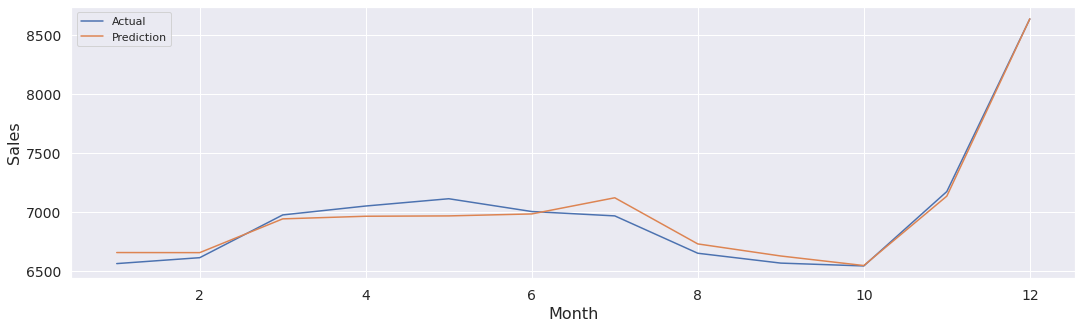

In [14]:
fig = rossmanPipeLine.pred_graph(res_df)

In [15]:
random_feat_imp = rossmanPipeLine.get_feature_importance(model).sort_values(by=["importance"], ascending=False)
display(random_feat_imp)

,features,importance
0,DayOfWeek,0.259993
2,Promo,0.158251
5,StoreType,0.135396
10,Promo2,0.092805
11,Promo2SinceWeek,0.083640
8,CompetitionOpenSinceMonth,0.044732
17,Day,0.041122
15,Year,0.041021
9,CompetitionOpenSinceYear,0.033307
13,PromoInterval,0.033083


let us plot importance of feature

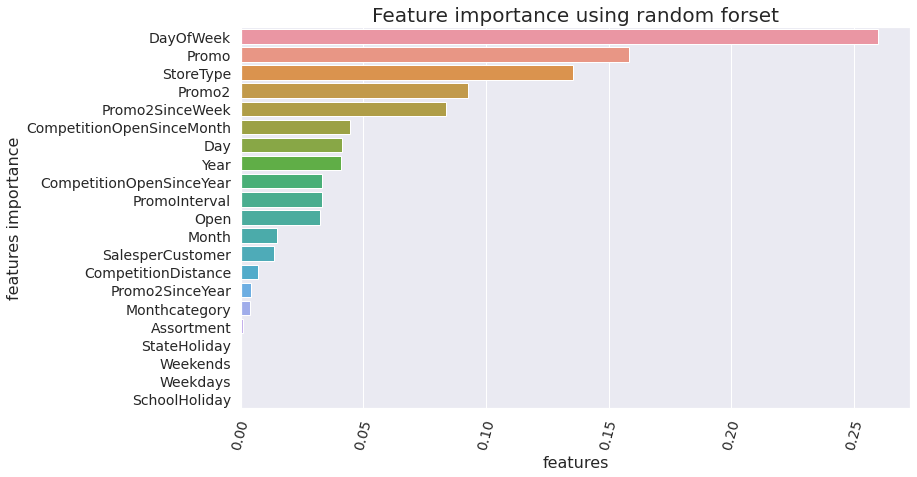

In [16]:
plot.plot_bar(random_feat_imp,  "importance", "features","Feature importance using random forset", "features",
               "features importance")

## Sales Prediction Using Linear Regressor

In [17]:
rossmanPipeLine2 = RossManPipeline(df_train_store, "LinearRegression")
pipeline2, model2 = rossmanPipeLine2.train(regressor= LinearRegression())

(675470, 21)


2021/08/02 03:56:03 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('numric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['CompetitionDistance', 'Promo2SinceWeek',
                             ...`
2021/08/02 03:56:03 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('numric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['CompetitionDistance', 'Promo2SinceWeek',
                                  'SalesperCust...`
2021/08/02 03:56:03 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('numric', Pipeline(steps=[('scaler', StandardScaler())]), ['CompetitionDistance', 'Promo2SinceWeek', 'SalesperCustomer']), ('category', Pipeline(steps=[('encoder', Or

step score of model is: 0.203
step Mean abs error of model is: 2001.591


,Prediction Sales,Actual Sales
Month,,
1,6598.994504,6562.932683
2,6611.332067,6613.008372
3,6817.695867,6975.028942
4,6876.496114,7050.398191
5,6909.555842,7112.009881
6,6953.413612,7003.768669
7,7204.055292,6966.741972
8,7016.874443,6650.534899
9,7003.414885,6567.055455


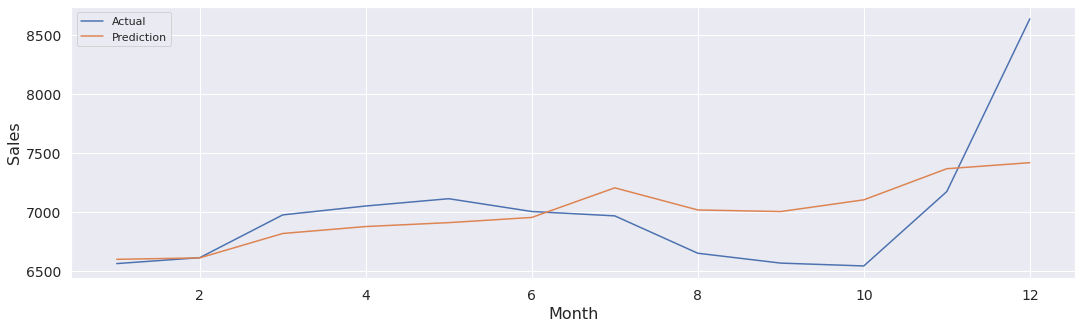

In [18]:
score_2, loss_2, res_df_2 = rossmanPipeLine2.test(model2)
display(res_df_2)
fig = rossmanPipeLine2.pred_graph(res_df_2)